# K-FOLDS

In [58]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 1- filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# 2- wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# 3- embedded methods
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [59]:
techscape = pd.read_csv('train.csv')

In [60]:
# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 


techscape.Country = techscape.Country.astype('string') 


techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 


techscape.Type_of_Traffic = techscape.Type_of_Traffic.astype('string') 

techscape.Browser = techscape.Browser.astype('string') 


techscape.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   9999 non-null   string        
 1   Date                        9999 non-null   datetime64[ns]
 2   AccountMng_Pages            9999 non-null   int64         
 3   AccountMng_Duration         9999 non-null   float64       
 4   FAQ_Pages                   9999 non-null   int64         
 5   FAQ_Duration                9999 non-null   float64       
 6   Product_Pages               9999 non-null   int64         
 7   Product_Duration            9999 non-null   float64       
 8   GoogleAnalytics_BounceRate  9999 non-null   float64       
 9   GoogleAnalytics_ExitRate    9999 non-null   float64       
 10  GoogleAnalytics_PageValue   9999 non-null   float64       
 11  OS                          9999 non-null   string      

In [61]:
# Separate the metric variables from the non metric ones 
#non_metric_features = ['Access_ID', 'Date',"OS", "Browser", "Country", "Type_of_Traffic", "Type_of_Visitor", 'Buy'] 
#metric_features = techscape.columns.drop(non_metric_features).to_list()

metric_features = techscape.select_dtypes(include=np.number).set_index(techscape.index).columns.to_list()
non_metric_features = techscape.select_dtypes(exclude=np.number).set_index(techscape.index).columns.to_list()

non_metric_features

['Access_ID',
 'Date',
 'OS',
 'Browser',
 'Country',
 'Type_of_Traffic',
 'Type_of_Visitor']

In [62]:
# Pages and Duration variables

# usually, it doeesn´t make sense that Pages > 0 and Duration = 0. However, there are too many observations like that,
# so, in instead of removing them, we decided to convert (duration = 0, pages=1)  --> (duration = 1, pages=1)

#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.drop(account_index, axis=0, inplace=True)
techscape.loc[techscape['AccountMng_Duration']==0,'AccountMng_Duration'] = 1
techscape

#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.drop(faq_index, axis=0, inplace=True)
techscape.loc[techscape['FAQ_Duration']==0,'FAQ_Duration'] = 1
techscape

#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.drop(product_index, axis=0, inplace=True)
techscape.loc[techscape['Product_Duration']==0,'Product_Duration'] = 1
techscape


# Total removed = 3 + 9 + 130 = 142 (1.42%)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0
9995,798314158,2020-07-17,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0
9996,798339820,2020-03-23,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0
9997,798371242,2020-05-16,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0


In [63]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (techscape['GoogleAnalytics_BounceRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_ExitRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_PageValue']<= 80)
    &
    (techscape['AccountMng_Pages']<= 18)  
    &
    (techscape['FAQ_Pages']<=7)
    &
    (techscape['FAQ_Duration']<=700)
    &
    (techscape['FAQ_Duration']<=700)    
)

print(filters1)
techscape_1 = techscape[filters1]

perc_outliers1 = np.round((techscape.shape[0] - techscape_1.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers1}%')

0       True
1       True
2       True
3       True
4       True
        ... 
9994    True
9995    True
9996    True
9997    True
9998    True
Length: 9857, dtype: bool
Percentage of observations removed: 10.54%


In [64]:
# ------------------  Interquantile method ------------------

#q25 = techscape.quantile(.25)
#q75 = techscape.quantile(.75)
#iqr = (q75 - q25)

techscape_mean, techscape_std = np.mean(techscape), np.std(techscape)

# We can change the number of stds
upper_lim = techscape_mean + 5 * techscape_std   
lower_lim = techscape_mean - 5 * techscape_std

filters2 = []

for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    
    filters2.append(techscape[metric].between(llim, ulim, inclusive=True))
    


filters2 = pd.Series(np.all(filters2, 0))
filters2=filters2.values


techscape_2 = techscape[filters2]

perc_outliers2 = np.round((techscape.shape[0] - techscape_2.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers2}%')

Percentage of observations removed: 3.48%


In [65]:
techscape_3 = techscape[(filters1 | filters2)]

perc_outliers3 = np.round((techscape.shape[0] - techscape_3.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of outliers removed: {perc_outliers3}%')

Percentage of outliers removed: 2.0%


In [66]:
techscape=techscape_3.copy()

In [67]:
# Create new variables

# Create binary variables for operating systems
techscape['Apple'] = techscape['OS'].apply(lambda x: str(1) if x == 'MacOSX' or x == 'iOS' else str(0))  
techscape['Windows'] = techscape['OS'].apply(lambda x: str(1) if x == 'Windows' else str(0))  
techscape['Android'] = techscape['OS'].apply(lambda x: str(1) if x == 'Android' else str(0))



# Create binary variables for countries
techscape['Portugal'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' else str(0)) 
#techscape['European Union'] = techscape['Country'].apply(lambda x: 0 if x == 'United Kingdom' or x == 'Other' or x == 'Brazil' else 1)
techscape['Iberian_Peninsula'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' or x == 'Spain' else str(0))
techscape['Spain'] = techscape['Country'].apply(lambda x: str(1) if x == 'Spain' else str(0))


# Create binary variables for type of visitors
techscape['Returner'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'Returner' else str(0)) 
techscape['New_Access'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'New_Access' else str(0))


# Create the total duration of the visits and total number of page visits
techscape['Total_Duration'] = techscape['AccountMng_Duration'] + techscape['FAQ_Duration'] + techscape['Product_Duration']
techscape['Total_Pages'] = techscape['AccountMng_Pages'] + techscape['FAQ_Pages'] + techscape['Product_Pages']

techscape.loc[techscape['Total_Pages']==0,'Total_Pages']=1


# Create the proportion of time on each page type
techscape['PropTime_AccountMng'] = techscape['AccountMng_Duration']/techscape['Total_Duration']
techscape['PropTime_FAQ'] = techscape['FAQ_Duration']/techscape['Total_Duration']
techscape['PropTime_Product'] = techscape['Product_Duration']/techscape['Total_Duration']

# Create the proportion of visited pages of each type
techscape['PropPages_AccountMng'] = techscape['AccountMng_Pages']/techscape['Total_Pages']
techscape['PropPages_FAQ'] = techscape['FAQ_Pages']/techscape['Total_Pages']
techscape['PropPages_Product'] = techscape['Product_Pages']/techscape['Total_Pages']

# Create the average time spent per page
techscape['AvgTimePerPage'] = techscape['Total_Duration'].div(techscape['Total_Pages'].values)
### avg time per type of page?



# Create the month of the visit
techscape['Month'] = techscape['Date'].dt.month


# Create variable Covid
techscape['Covid']=techscape['Month'].apply(lambda x: str(1) if x>3 else str(0))

techscape['Traffic2']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '2' else str(0))
techscape['Traffic3']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '3' else str(0)) 
techscape['Traffic4']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '4' else str(0)) 
techscape['Traffic5']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '5' else str(0)) 
techscape['Traffic6']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '6' else str(0)) 
techscape['Traffic7']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '7' else str(0))
techscape['Traffic8']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '8' else str(0)) 
techscape['Traffic9']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '9' else str(0)) 
techscape['Traffic10']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '10' else str(0)) 
techscape['Traffic11']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '11' else str(0)) 
techscape['Traffic12']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '12' else str(0)) 
techscape['Traffic13']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '13' else str(0)) 
techscape['Traffic14']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '14' else str(0)) 
techscape['Traffic15']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '15' else str(0)) 

 
techscape['Browser2']=techscape['Browser'].apply(lambda x: str(1) if x == '2' else str(0))
techscape['Browser3']=techscape['Browser'].apply(lambda x: str(1) if x == '3' else str(0)) 
techscape['Browser4']=techscape['Browser'].apply(lambda x: str(1) if x == '4' else str(0)) 
techscape['Browser5']=techscape['Browser'].apply(lambda x: str(1) if x == '5' else str(0)) 
techscape['Browser6']=techscape['Browser'].apply(lambda x: str(1) if x == '6' else str(0)) 
techscape['Browser7']=techscape['Browser'].apply(lambda x: str(1) if x == '7' else str(0))
techscape['Browser8']=techscape['Browser'].apply(lambda x: str(1) if x == '8' else str(0)) 
techscape['Browser9']=techscape['Browser'].apply(lambda x: str(1) if x == '9' else str(0)) 
techscape['Browser10']=techscape['Browser'].apply(lambda x: str(1) if x == '10' else str(0)) 
techscape['Browser11']=techscape['Browser'].apply(lambda x: str(1) if x == '11' else str(0)) 
techscape['Browser12']=techscape['Browser'].apply(lambda x: str(1) if x == '12' else str(0)) 
techscape['Browser13']=techscape['Browser'].apply(lambda x: str(1) if x == '13' else str(0))


techscape['Feb']=techscape['Browser'].apply(lambda x: str(1) if x == '2' else str(0))
techscape['Mar']=techscape['Browser'].apply(lambda x: str(1) if x == '3' else str(0)) 
techscape['Apr']=techscape['Browser'].apply(lambda x: str(1) if x == '4' else str(0)) 
techscape['May']=techscape['Browser'].apply(lambda x: str(1) if x == '5' else str(0)) 
techscape['Jun']=techscape['Browser'].apply(lambda x: str(1) if x == '6' else str(0)) 
techscape['Jul']=techscape['Browser'].apply(lambda x: str(1) if x == '7' else str(0))
techscape['Aug']=techscape['Browser'].apply(lambda x: str(1) if x == '8' else str(0)) 
techscape['Sep']=techscape['Browser'].apply(lambda x: str(1) if x == '9' else str(0)) 
techscape['Oct']=techscape['Browser'].apply(lambda x: str(1) if x == '10' else str(0)) 
techscape['Nov']=techscape['Browser'].apply(lambda x: str(1) if x == '11' else str(0)) 
techscape['Dec']=techscape['Browser'].apply(lambda x: str(1) if x == '12' else str(0)) 

techscape





,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,...,0,0,0,0,0,0,0,0,0,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,...,0,0,0,0,0,0,0,0,0,0
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,...,0,1,0,0,0,0,0,0,0,0
3,103226087,2020-12-22,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,...,0,0,0,0,0,0,0,0,0,0
4,103234445,2020-11-24,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,...,0,0,0,0,0,0,0,0,0,0
9995,798314158,2020-07-17,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,...,0,0,0,0,0,0,0,1,0,0
9996,798339820,2020-03-23,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,...,0,0,0,0,0,0,0,0,0,0
9997,798371242,2020-05-16,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Chi-Square for categorical data

target = techscape['Buy']
techscape.drop('Buy', axis=1, inplace=True)

techscape_cat = techscape.select_dtypes(exclude=np.number)

def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)
    
    
for var in techscape_cat:
    TestIndependence(techscape[var],target, var)
    
# Keep: Date, OS, Type_of_Visitor
# Remove: Access_ID, Country

Access_ID is NOT an important predictor. (Discard Access_ID from model)
Date is IMPORTANT for Prediction
OS is IMPORTANT for Prediction
Browser is IMPORTANT for Prediction
Country is NOT an important predictor. (Discard Country from model)
Type_of_Traffic is IMPORTANT for Prediction
Type_of_Visitor is IMPORTANT for Prediction
Apple is IMPORTANT for Prediction
Windows is IMPORTANT for Prediction
Android is NOT an important predictor. (Discard Android from model)
Portugal is NOT an important predictor. (Discard Portugal from model)
Iberian_Peninsula is NOT an important predictor. (Discard Iberian_Peninsula from model)
Spain is NOT an important predictor. (Discard Spain from model)
Returner is IMPORTANT for Prediction
New_Access is IMPORTANT for Prediction
Covid is IMPORTANT for Prediction
Traffic2 is IMPORTANT for Prediction
Traffic3 is IMPORTANT for Prediction
Traffic4 is NOT an important predictor. (Discard Traffic4 from model)
Traffic5 is NOT an important predictor. (Discard Traffic5 

# Retiramos outliers , incoerencias, adicionamos novas variaveis e selecionamos as variaveis categóricas. Em cada instancia do k-folds, vamos escalar a data e selecionar as variaveis numéricas a reter e estimar a performance de ummodelo


In [69]:

def avg_score_LR(method,X,y):
    score_train = []
    score_test = []
    for train_index, test_index in method.split(X):
        #print(train_index, test_index)
        print(method.get_n_splits)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = run_model_LR(X_train, y_train)
        #print(model.coef_)
        value_train = evaluate_model(X_train, y_train, model)
        value_test = evaluate_model(X_test,y_test, model)
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train:', np.mean(score_train))
    print('Test:', np.mean(score_test))

In [71]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [73]:
metric_features[:-1]

['AccountMng_Pages',
 'AccountMng_Duration',
 'FAQ_Pages',
 'FAQ_Duration',
 'Product_Pages',
 'Product_Duration',
 'GoogleAnalytics_BounceRate',
 'GoogleAnalytics_ExitRate',
 'GoogleAnalytics_PageValue']

Optimum number of features: 1
Score with 1 features: 0.888199
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration              False
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate      False
GoogleAnalytics_PageValue      True
dtype: bool


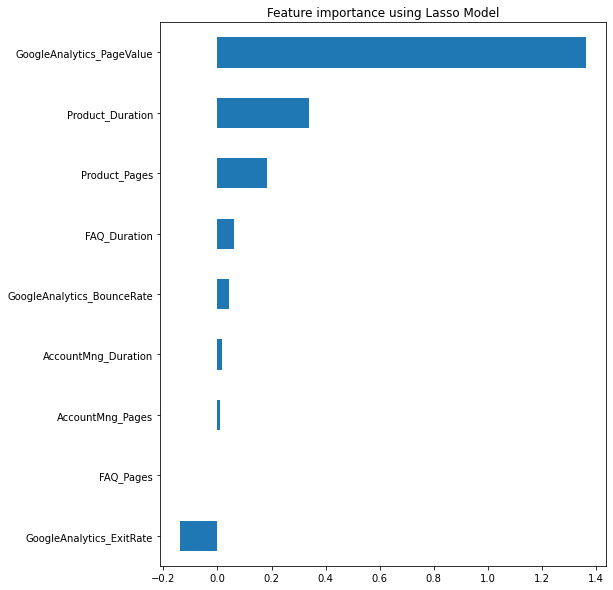

Optimum number of features: 2
Score with 2 features: 0.888199
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration              False
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool


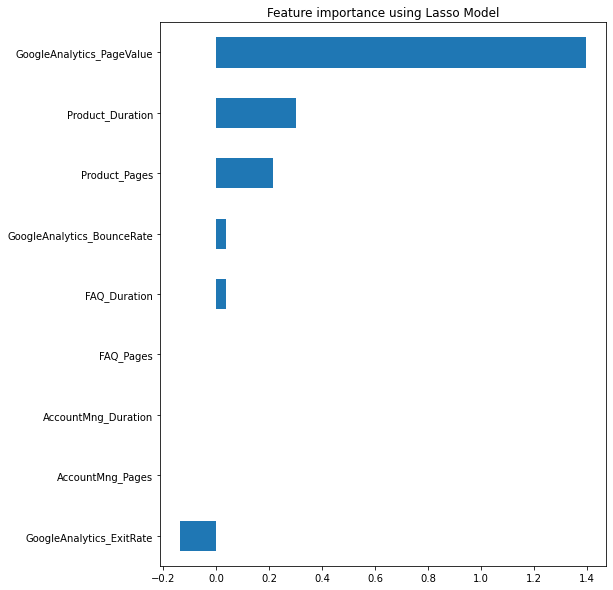

Optimum number of features: 1
Score with 1 features: 0.878882
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration              False
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate      False
GoogleAnalytics_PageValue      True
dtype: bool


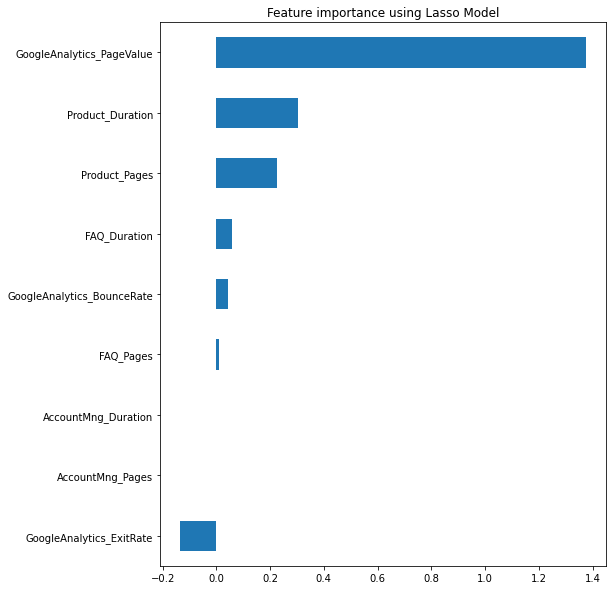

Optimum number of features: 3
Score with 3 features: 0.883023
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration               True
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool


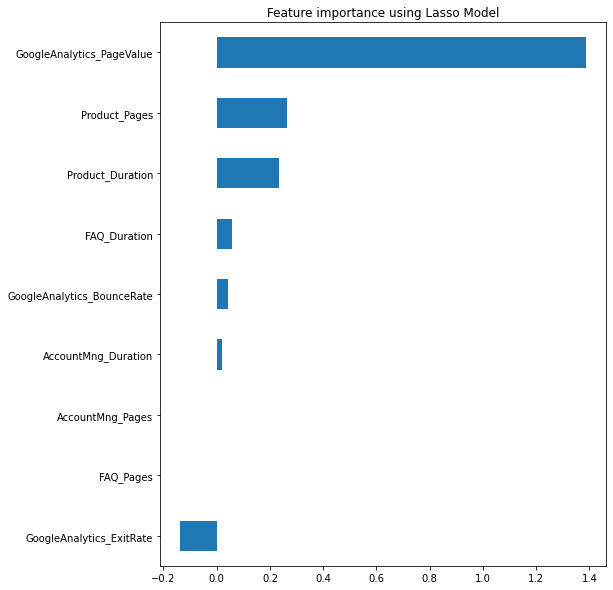

Optimum number of features: 7
Score with 7 features: 0.883023
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                      True
FAQ_Duration                   True
Product_Pages                  True
Product_Duration               True
GoogleAnalytics_BounceRate     True
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool


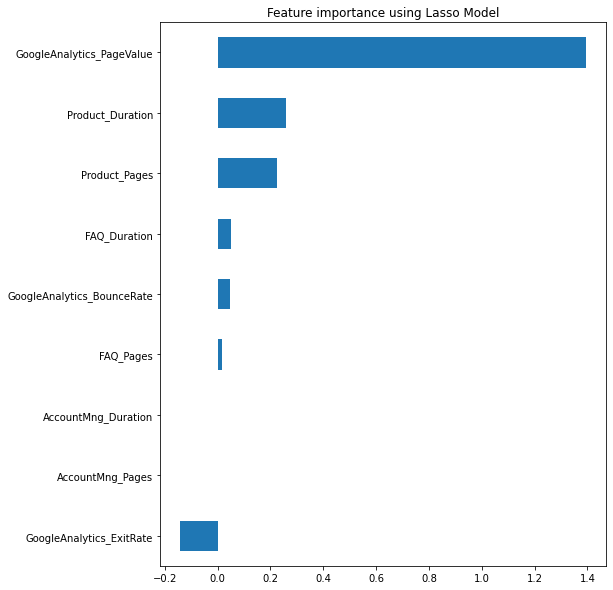

Optimum number of features: 1
Score with 1 features: 0.881988
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration              False
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate      False
GoogleAnalytics_PageValue      True
dtype: bool


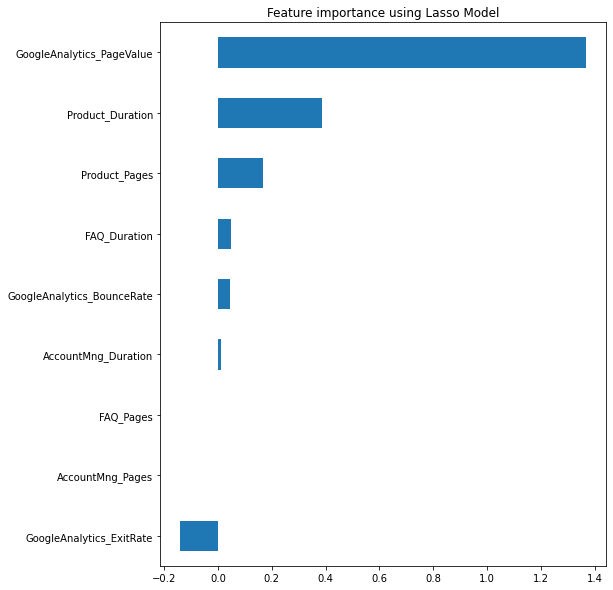

Optimum number of features: 2
Score with 2 features: 0.904762
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration              False
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool


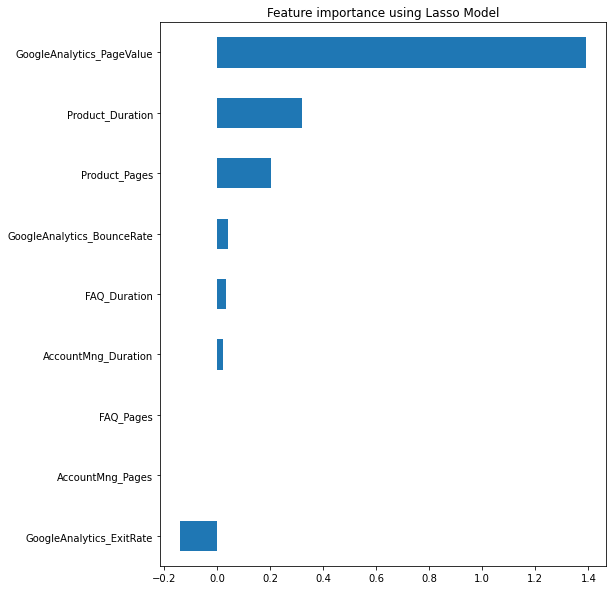

Optimum number of features: 1
Score with 1 features: 0.875776
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration              False
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate      False
GoogleAnalytics_PageValue      True
dtype: bool


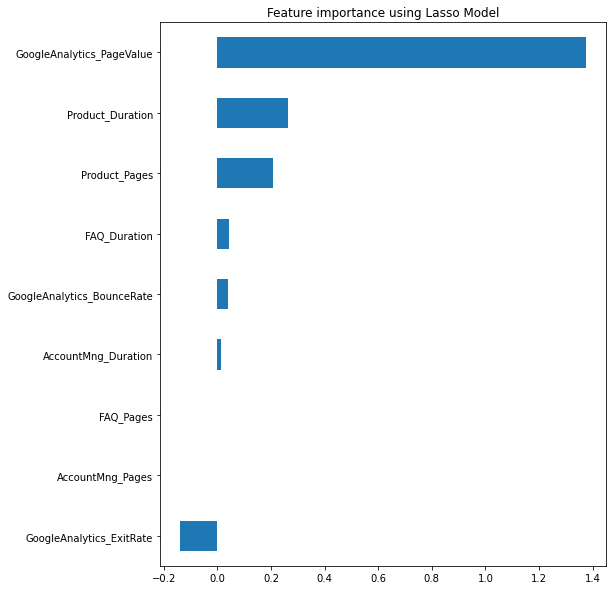

Optimum number of features: 4
Score with 4 features: 0.875776
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                  True
Product_Duration               True
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool


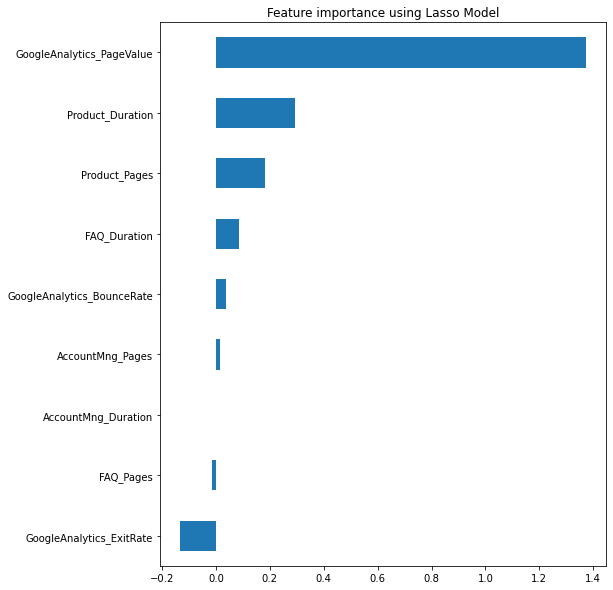

Optimum number of features: 3
Score with 3 features: 0.899586
Selected features:

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration               True
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool


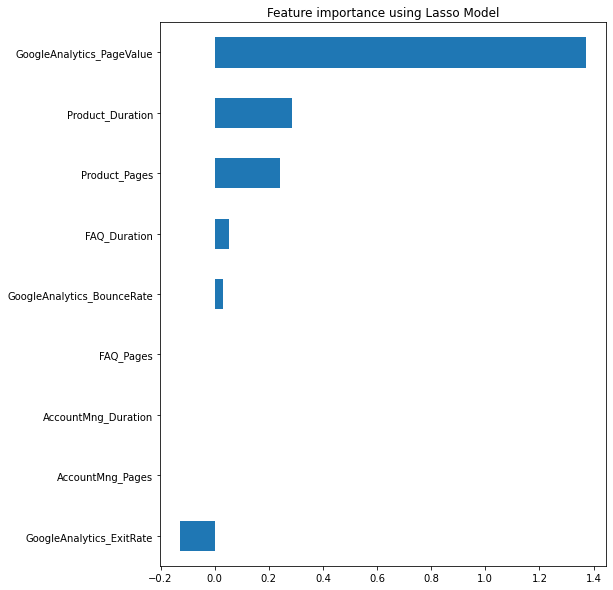

In [78]:
kf = KFold(n_splits=10)

X=techscape[metric_features[:-1]]


for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        
        ## Scaling the data
        
        scaler = MinMaxScaler().fit(X_train)
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        ## Convert the array to a pandas dataframe
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)


        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        nof_list=np.arange(1,len(metric_features))            
        high_score=0
        
        # Variable to store the optimum features
        nof=0           
        score_list =[]
        for n in range(len(nof_list)):
            model = LogisticRegression()
            rfe = RFE(model,nof_list[n])
            X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
            X_val_rfe = rfe.transform(X_val_metric_scaled)
            model.fit(X_train_rfe,y_train)
            
            score = model.score(X_val_rfe,y_val)
            score_list.append(score)
            
            if(score>high_score):
                high_score = score
                nof = nof_list[n]
        print("Optimum number of features: %d" %nof)
        print("Score with %d features: %f" % (nof, high_score))
        
        model = LogisticRegression()
        rfe = RFE(estimator = model, n_features_to_select = nof)
        X_rfe = rfe.fit_transform(X = X_train_metric_scaled, y = y_train)
        
        selected_features = pd.Series(rfe.support_, index = X_train_metric_scaled.columns)
        print('Selected features:')
        print('')
        print(selected_features)

        reg = LassoCV()
        reg.fit(X_train_metric_scaled, y_train)
        
        coef = pd.Series(reg.coef_, index = X_train_metric_scaled.columns)
        coef.sort_values()
        
        plot_importance(coef,'Lasso')
        




In [75]:
# Check the best number of features to retain

nof_list=np.arange(1,len(metric_features))            
high_score=0

# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_metric_scaled)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

# Quais as 2 features?

Optimum number of features: 2
Score with 2 features: 0.885921


In [ ]:
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 3)
X_rfe = rfe.fit_transform(X = techscape, y = y_train)

selected_features = pd.Series(rfe.support_, index = X_train_metric_scaled.columns)
print(selected_features)

In [ ]:
# ------------ 3- Embedded methods (Lasso Regression) ------------

def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
reg = LassoCV()
reg.fit(X_train_metric_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_metric_scaled.columns)
coef.sort_values()

plot_importance(coef,'Lasso')